In [1]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Load the annotations.

In [2]:
import json
import pandas as pd

sats = []

with open('data/spotGEO/train_anno.json') as f:
    for ann in json.load(f):
        for i, coords in enumerate(ann['object_coords']):
            sats.append({
                'sequence': ann['sequence_id'],
                'frame': ann['frame'],
                'satellite': i + 1,
                'x': coords[0],
                'y': coords[1],
            })
    
sats = pd.DataFrame(sats)
sats = sats.set_index(['sequence', 'frame', 'satellite'])
sats.head()

x           y
sequence frame satellite                        
1        1     1          502.406250  237.114583
               2          490.381836  221.811523
               3          140.874332  129.093583
         2     1          530.406250  214.114583
               2          518.381836  198.811523

Load the images.

In [3]:
import pathlib
from PIL import Image
import numpy as np

train = {
    (int(seq.name), int(frame.stem)): np.asarray(Image.open(frame)).astype(np.float32)
    for seq in pathlib.Path('data/spotGEO/train').glob('*')
    for frame in seq.glob('*.png')
}

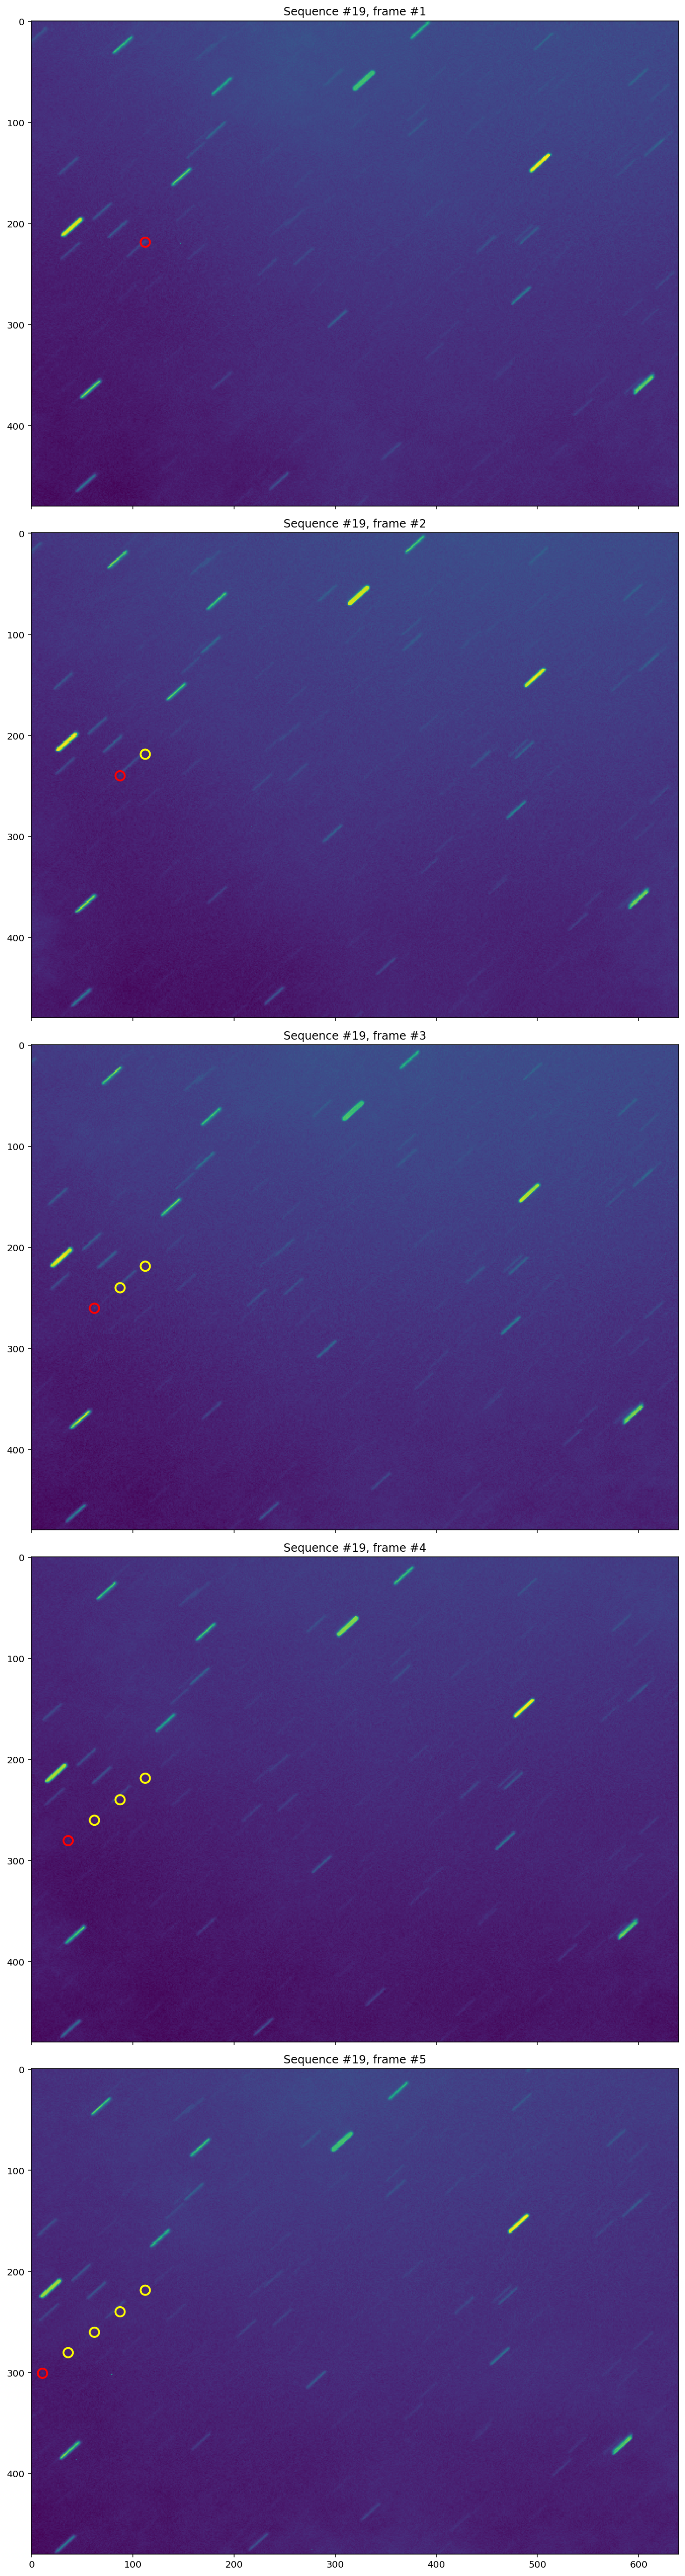

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import ImageGrid

def viz_sequence(seq, df):
    
    # Make one image for each frame
    fig = plt.figure(figsize=(15, 10 * 5)) # 5 frames in each sequence
    grid = ImageGrid(
        fig, 111,  
        nrows_ncols=(5, 1),
        axes_pad=.4,
    )

    frames = df.loc[seq]
    trajectories = []

    for frame, sats in frames.groupby('frame'):
    
        # Sky
        ax = grid[frame - 1]
        ax.imshow(train[seq, frame], origin='lower')
        ax.set_title(f'Sequence #{seq}, frame #{frame}')

        # Current positions
        for _, sat in sats.iterrows():
            ax.scatter(sat['x'], sat['y'], s=100, facecolors='none', edgecolors='red', linewidths=2)
            
        # Old positions
        for old_sats in trajectories:
            for _, sat in old_sats.iterrows():
                ax.scatter(sat['x'], sat['y'], s=100, facecolors='none', edgecolors='yellow', linewidths=2)
        trajectories.append(sats)
        
        ax.set_xlim(-.5, 639.5)
        ax.set_ylim(479.5, -.5)
    
    return fig

fig = viz_sequence(19, df=sats)

Now let's load the interesting pixels, those that have the potential of being satellites.

In [30]:
interesting = pd.read_pickle('data/interesting.pkl')

In [31]:
interesting

r       c is_satellite
part  sequence frame                                 
test  1        1       40.000000   10.00         None
               1       56.000000  455.00         None
               1       58.000000  450.00         None
               1       60.411765   39.00         None
               1       70.000000  617.00         None
...                          ...     ...          ...
train 1280     5      393.500000   67.75        False
               5      447.000000  636.00        False
               5      456.000000  273.00        False
               5      463.000000  290.00        False
               5      478.285714  107.00        False

[1932733 rows x 3 columns]

## Feature extraction

In [24]:
import numpy as np

def region(img: np.ndarray, r: int, c: int, w: int):
    """Returns the square of length width with (x, y) being at the center."""
    return img[
        max(r - w, 0) : min(r + w + 1, img.shape[0]),
        max(c - w, 0) : min(c + w + 1, img.shape[1])
    ]

def extract_features(img, r, c):
    r3x3 = region(img, r, c, 3)
    r5x5 = region(img, r, c, 5)
    val = img[r, c]
    return {
        'pixel_value': val,
        '3x3_std': r3x3.std(),
        '3x3_min': val - r3x3.min(),
        '3x3_max': val - r3x3.max(),
        '5x5_std': r5x5.std(),
        '5x5_min': val - r5x5.min(),
        '5x5_max': val - r5x5.max()
    }

Negative samples.

In [43]:
import tqdm

samples = {}

for (part, sequence, frame), locations in tqdm.tqdm(interesting.groupby(['part', 'sequence', 'frame']), position=0):
    
    img = np.asarray(Image.open(f'data/spotGEO/{part}/{sequence}/{frame}.png')).astype(np.float32)
    
    for _, location in locations.iterrows():
    
        r = int(location['r'])
        c = int(location['c'])

        samples[part, sequence, frame, r, c] = {
            'is_satellite': location['is_satellite'],
            **extract_features(img, r=r, c=c)
        }
        
samples = pd.DataFrame.from_dict(samples, orient='index')
samples.index.names = ['part', 'sequence', 'frame', 'r', 'c']
samples.head()

100%|██████████| 31996/31996 [10:14<00:00, 52.09it/s] 


is_satellite  pixel_value   3x3_std  3x3_min  \
part sequence frame r  c                                                  
test 1        1     40 10          None         56.0  3.083322     14.0   
                    56 455         None         53.0  3.457242     14.0   
                    58 450         None         54.0  3.459770     15.0   
                    60 39          None         56.0  4.336242     13.0   
                    70 617         None         50.0  3.441666     14.0   

                            3x3_max   5x5_std  5x5_min  5x5_max  
part sequence frame r  c                                         
test 1        1     40 10       0.0  2.851707     15.0      0.0  
                    56 455      0.0  2.998075     14.0     -1.0  
                    58 450      0.0  3.354211     15.0      0.0  
                    60 39      -3.0  3.776905     15.0     -3.0  
                    70 617      0.0  3.049150     14.0      0.0

## Learning phase

In [50]:
from sklearn import utils

X_train = samples.loc['train'].copy()
y_train = X_train.pop('is_satellite').astype(bool)
X_train, y_train = utils.shuffle(X_train, y_train, random_state=42)

X_test = samples.loc['test'].drop(columns='is_satellite')

In [51]:
import lightgbm
from sklearn import metrics
from sklearn import model_selection
from sklearn import utils

model = lightgbm.LGBMClassifier(
    random_state=42
)

cv = model_selection.GroupKFold(n_splits=5)
groups = X_train.index.get_level_values('sequence')
oof = pd.Series(dtype=bool, index=X_train.index)
y_test = pd.DataFrame(index=X_test.index)

for i, (fit_idx, val_idx) in enumerate(cv.split(X_train, y_train, groups=groups)):
    
    X_fit = X_train.iloc[fit_idx]
    y_fit = y_train.iloc[fit_idx]
    X_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    model.fit(
        X_fit, y_fit,
        eval_set=[(X_fit, y_fit), (X_val, y_val)],
        eval_names=['fit', 'val'],
        verbose=30
    )
    oof.iloc[val_idx] = model.predict(X_val)
    
    y_test[i] = model.predict_proba(X_test)[:, 1]
    
    print()

print(metrics.classification_report(y_train, oof, digits=4))

[30]	fit's binary_logloss: 0.0307464	val's binary_logloss: 0.0334559
[60]	fit's binary_logloss: 0.0266054	val's binary_logloss: 0.0307296
[90]	fit's binary_logloss: 0.0244123	val's binary_logloss: 0.0295602

[30]	fit's binary_logloss: 0.0306169	val's binary_logloss: 0.0369198
[60]	fit's binary_logloss: 0.0261807	val's binary_logloss: 0.0339232
[90]	fit's binary_logloss: 0.0239135	val's binary_logloss: 0.0327952

[30]	fit's binary_logloss: 0.0303809	val's binary_logloss: 0.0345645
[60]	fit's binary_logloss: 0.0259095	val's binary_logloss: 0.0325943
[90]	fit's binary_logloss: 0.0237044	val's binary_logloss: 0.0319484

[30]	fit's binary_logloss: 0.0312132	val's binary_logloss: 0.0327254
[60]	fit's binary_logloss: 0.0269534	val's binary_logloss: 0.0295411
[90]	fit's binary_logloss: 0.0250685	val's binary_logloss: 0.0294888

[30]	fit's binary_logloss: 0.0307667	val's binary_logloss: 0.0341594
[60]	fit's binary_logloss: 0.0265037	val's binary_logloss: 0.0313277
[90]	fit's binary_logloss: 0.0

In [52]:
oof.value_counts(normalize=True)

False    0.987539
True     0.012461
dtype: float64

In [71]:
(y_test.mean(axis='columns') > .5).value_counts(normalize=True)

False    0.986988
True     0.013012
dtype: float64

## Make the submission

Build it according to the specified format.

In [66]:
sub = []

for (sequence, frame), g in (y_test.mean(axis='columns') > .5).groupby(['sequence', 'frame']):
    
    coords = []
    
    for (*_, r, c), label in g.iteritems():
        if label:
            coords.append([c - .5, r - .5])
            
    sub.append({
        'sequence_id': int(sequence),
        'frame': int(frame),
        'num_objects': len(coords),
        'object_coords': coords
    })
    
assert len(sub) == 5120 * 5

Save it and zip it.

In [78]:
import json
import os
import zipfile

with open('submission.json', 'w') as f:
    json.dump(sub, f)
    
with zipfile.ZipFile('submission.zip', mode='w') as f:
    f.write('submission.json')
    
os.remove('submission.json')